# Spark Project

Spark project

author(s): Hao Ye , UID: 23376; Pierre-Louis Landouzi , UID: 23264

Group num: 404

Group name: ClownSquad

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions
from pyspark.sql.functions import udf, isnan, when, count, col, lit, expr, desc, mean, date_sub, next_day, year, date_format, pandas_udf, PandasUDFType
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import datetime

In [2]:
spark_application_name = "Spark_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

22/05/21 22:28:21 WARN Utils: Your hostname, MacBook-Air-de-Hao.local resolves to a loopback address: 127.0.0.1; using 192.168.0.40 instead (on interface en0)
22/05/21 22:28:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/21 22:28:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/21 22:28:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/21 22:28:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
stocks_path = 'stocks_data/MICROSOFT.csv'
another_sck_path = 'stocks_data/AMAZON.csv'

### Read Data function

In [4]:
def get_data(path, schema, header=True, delimiter=';'):
    """Get datas from path

    Parameters
    ----------
    path : string
        file location
    schema : StructType
        Schema for dataframe
    header: bool
        Take the header or not, default True
    delimiter: 
        the delimiter of the input file, default ;
    Returns
    -------
        DataFrame
    """
    
    extension = path.split('.')[-1]
    if (extension == "csv"):
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    elif (extension == 'json'):
        df = spark.read.json(path, schema)
    else:
        # join all csv in a folder
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    return df


In [5]:
def show_first_rows(df):
    """Show the first 40 rows

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.show(40)

In [6]:
def show_last_rows(df):
    """Show the last 40 rows

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    spark.createDataFrame(df.tail(40)).show()

In [7]:
def get_num_rows(df):
    """Show the number of rows

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    print('Number of rows: ' + str(df.count()))

In [8]:
def days_to_period(nb_days):
    if (nb_days > 365):
        return 'year'
    elif (nb_days > 28):
        return 'month'
    elif (nb_days > 7):
        return "week"
    else:
        return 'day'

def get_period(df):
    """Show the time period of Dataframe 

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.select("Date")
    # Create a by 1 shift column 
    my_window = Window.partitionBy().orderBy("Date")
    # Assign on prev_date column
    df = df.withColumn("prev_date", functions.lag(df.Date).over(my_window))
    # Compute diff between Date column and prev_date column and save on delta column
    df = df.withColumn("delta", functions.when(functions.isnull(df['Date'].cast("long") - df['prev_date'].cast('long')), 0)
                              .otherwise(df['Date'].cast('long') - df['prev_date'].cast('long')))
    # Compute diff in days
    df = df.withColumn("delta_days" , df['delta']/(24*3600))
    # Transform function to udf, just like .apply in pandas
    udf_days_to_period = udf(lambda x:days_to_period(x),StringType())
    
    # Compute the period according to days
    df = df.withColumn("period", udf_days_to_period(df['delta_days']))
    
    df = df.groupBy("period").count()
    df = df.sort(df["count"].desc())
    X = df.collect()[0][0]
    print('The period is a ' + str(X) + ' period')

In [9]:
def get_stats(df):
    """Show statistics of Dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.summary().show()

In [10]:
def get_na(df):
    """Show the number of missing values for each column

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    # Cast timestamp to long for check null
    df2 = df.withColumn("Date_long", df['Date'].cast('long'))
    df2 = df2.drop(df2['Date'])
    df2 = df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns])
    df2.show()

In [11]:
def plot_corr(df):
    """Plot the correlation matrix

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.drop(*('Date', 'company_name'))
    columns = df.columns
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
    
    matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
    corrmatrix = matrix.toArray().tolist()

    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+columns)
    ax.set_yticklabels(['']+columns)
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

In [12]:
def get_period_avg(df, period='week'):
    """Get a period average for Open and Close columns

    Parameters
    ----------
    df : DataFrame
    
    period : string
        la period pour la moyenne, par défaut week
    Returns
    -------
        DataFrame
    """
    
    df = df.select('Date', 'Open', 'Close')
    if (period == 'week'):
        df = df.withColumn("week_strt_day",date_sub(next_day(col("Date"),"sunday"),7)) \
               .groupBy("week_strt_day") \
                .agg(mean("Open").alias("weekly_avg_open"), mean("Close").alias("weekly_avg_open")) \
               .orderBy("week_strt_day")
    elif (period == 'month'):
        df = df.withColumn("month", date_format(col('Date'), 'yyyy/MM/1')) \
               .groupBy("month") \
                .agg(mean("Open").alias("monthly_avg_open"), mean("Close").alias('monthly_avg_close'))\
               .orderBy('month')
    elif (period == 'year'):
        df = df.withColumn("year", year(col('Date'))) \
               .groupBy("year") \
                .agg(mean("Open").alias("annualy_avg_open"), mean("Close").alias('annualy_avg_close'))\
               .orderBy('year')
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
        
    # Maybe plot a graph ?
    return df

In [13]:
def get_evolution(df, period='day'):
    """Get the price evolution for each numeric column

    Parameters
    ----------
    df : DataFrame
    
    period : string
        l'échelle de l'évolution, par défaut day
    Returns
    -------
        DataFrame
    """
    w = Window.partitionBy().orderBy("Date")
    if (period == 'day'): 
        df_prev = df.withColumn('prev_high', functions.lag(df['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df['Close']).over(w))
    
    elif (period == 'month'):
        df_group_by_month = df.select('Date', 'High', 'Low', 'Open', 'Close') \
                              .withColumn("Date", date_format(col('Date'), 'yyyy/MM/1')) \
                              .groupBy("Date")\
                              .agg(functions.sum("High").alias("High"), 
                                   functions.sum("Low").alias("Low"), 
                                   functions.sum("Open").alias("Open"), 
                                   functions.sum("Close").alias("Close"))\
                              .orderBy('Date')
        
        df_prev = df_group_by_month.withColumn('prev_high', functions.lag(df_group_by_month['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df_group_by_month['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df_group_by_month['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df_group_by_month['Close']).over(w))
    else:
        raise ValueError("Incorrect period format, expected day, month")
        
    result_df = df_prev.withColumn('delta_high', df_prev['High'] - df_prev['prev_high']) \
                   .withColumn('delta_low', df_prev['Low'] - df_prev['prev_low']) \
                   .withColumn('delta_open', df_prev['Open'] - df_prev['prev_open']) \
                   .withColumn('delta_close', df_prev['Close'] - df_prev['prev_close']) \
                   .select('Date', 'delta_high', 'delta_low', 'delta_open', 'delta_close')
    
    return result_df

In [14]:
def dailyReturn(df):
    """Get the daily return

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        DataFrame
    """
    return df.select(col("company_name"), col("Date"), expr("(Close - Open) as dailyReturn"))

In [15]:
from pyspark.sql.functions import desc, max

def bestDailyReturn(df):
    """Get the best daily return of a Dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        DataFrame
    """
    return df.select(col("company_name"), expr("(Close - Open) as dailyReturn"))\
        .groupBy(col('company_name'))\
        .agg(max('dailyReturn'))

In [16]:
def averageDailyReturnByWeek(df):
    """Get the average daily return by week

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        DataFrame
    """
    return dailyReturn(df)\
    .withColumn("Date",date_sub(next_day(col("Date"),"sunday"),7))\
    .groupBy("company_name", "Date").mean("dailyReturn")

def averageDailyReturnByMonth(df):
    """Get the average daily return by month

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        DataFrame
    """
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy-MM"))\
    .groupBy("company_name", "Date").mean("dailyReturn")

def averageDailyReturnByYear(df):
    """Get the average daily return by year

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        DataFrame
    """
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy"))\
    .groupBy("company_name", "Date").mean("dailyReturn")

In [17]:
def moving_averge(df, column='Open', moving_range=5):
    """Get the MMA of a Dataframe

    Parameters
    ----------
    df : DataFrame
        
    column : string
        column name, default Open
    moving_range: int
        period, deault 5
        
    Returns
    -------
    DataFrame
    """
    check = df.select(col(column), col(column).cast("int").isNotNull().alias("Value")).select("Value").collect()
    if_all_true = all(e for e in check)
    if (if_all_true):
        w = (Window.orderBy(functions.col("Date")).rowsBetween(-moving_range, 0))
        df = df.withColumn('moving_average', functions.mean(column).over(w))\
               .select('Date', column, 'moving_average')
        return df
    else: 
        raise ValueError("Selected column is not numeric type")

In [18]:
def corr_with(df1, df2):
    """Plot the correlation matrix between 2 Dataframes

    Parameters
    ----------
    df1 : DataFrame
        1st Dataframe
        
    df2 : DataFrame
        2nd Dataframe
    Returns
    -------
        Void
    """
    df1 = df1.select(col('Date').alias('Date1'),
                     col('Low').alias('Low-1'), 
                     col('High').alias('High-1'), 
                     col('Open').alias('Open-1'),
                     col('Close').alias('Close-1'),
                     col('Volume').alias('Volume-1'),
                     col('Adj Close').alias('Adj Close-1'))

    
    df2 = df2.select(col('Date').alias('Date2'),
                     col('Low').alias('Low-2'), 
                     col('High').alias('High-2'), 
                     col('Open').alias('Open-2'),
                     col('Close').alias('Close-2'),
                     col('Volume').alias('Volume-2'),
                     col('Adj Close').alias('Adj Close-2'))
    
    df = df1.join(df2, df1.Date1 == df2.Date2 ,how='inner').drop(*('Date1', 'Date2'))
    columns = list(df.columns)
    
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
     
    matrix = Correlation.corr(myGraph_vector, vector_col)
    corrmatrix = matrix.collect()[0][matrix.columns[0]].toArray()
    
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    ax.set_yticks(np.arange(len(columns), step=1), labels=columns)
    ax.set_xticks(np.arange(len(columns), step=1), labels=columns, rotation=90)
    fig.colorbar(cax)
    plt.show()

In [19]:
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")


def RoR(df, date, period):
    """Get the return rate of the stock in different periods

    Parameters
    ----------
    df : DataFrame
        
    date : String
        starting date
        
    period: String
    
    Returns
    -------
        Float
    """
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "week":
        currentDate += datetime.timedelta(days=7)  
    elif period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
   

    tmp = df.select(col("Date"), col("Open"))
    
    # Get rows and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
    
    currentRow = tmp.filter(col("Date") == currentDate).first()
    if(currentRow == None):
        raise ValueError("Incorrect date:", currentDate.strftime("%Y-%m-%d"))
    
    # Get values
    originalVal = float(originalRow.__getitem__('Open'))
    currentValue = float(currentRow.__getitem__('Open'))
    
    # Return the calcul
    return (currentValue - originalVal) / originalVal * 100

In [20]:
def bestRoR(df, date, period):
    """Get the best return rate of the stock in different periods

    Parameters
    ----------
    df : DataFrame
        
    date : String
        starting date
        
    period: String
    
    Returns
    -------
        Float
    """
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected month or year")
    
    tmp = df.select(col("Date"), col("Open"))
    
    
    # Get originalRow and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
        
    # Get original values
    originalVal = float(originalRow.__getitem__('Open'))
    
    
    # Get the period rows and add a column corresponding to the RoR
    tmp = tmp.where(col("Date") > originalDate) \
        .where(col("Date") <= currentDate) \
        .withColumn("originalVal", lit(originalVal)) \
        .select("Date", expr("((Open - originalVal) / originalVal * 100) as RoR"))
    
    # Get the row with the highter
    bestRoRRow = tmp.orderBy(desc("RoR")).first()
    
    
    # Return the tupple (Date, RoR)
    return (bestRoRRow.__getitem__('Date'), bestRoRRow.__getitem__('RoR'))

## Insights 

### 1) EMA

In [21]:
def get_EMA(df, p=5, column='Open'):
    """Plot Exponential moving average

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 5
    
    columns: string
        Open or Close, default Open
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def ema(pdf):
        return pdf.ewm(com = p - 1, adjust=True, min_periods = p).mean()
    
    df = df.withColumn('ewm', ema(col(column)))
    
    Date = [val for val in df.select('Date').collect()]
    rsi = [val for val in df.select('ewm').collect()]
    ref = [val for val in df.select(column).collect()]
    
    plt.figure(figsize=(20,10))
    plt.title("Exponential moving average")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, rsi, label= 'EMA with ' + str(p) + ' period')
    plt.plot(Date, ref, label= column)

    plt.legend()
    plt.show()

### 2) Rate of Change

In [22]:
def get_ROC(df, p=10):
    """Plot Rate of Change curve

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 10
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def roc(pdf):
        difference = pdf.diff(p)
        nprev_values = pdf.shift(p)
        return (difference / nprev_values) * 100
    
    df = df.withColumn('roc', roc(col('Close')))
    
    Date = [val for val in df.select('Date').collect()]
    rate_of_change = [val for val in df.select('roc').collect()]
    ref = [val for val in df.select('Close').collect()]
    
    figure, axis = plt.subplots(2, 1, figsize=(15,15))

    axis[0].plot(Date, ref, label= 'Close')
    axis[0].set_title('Close evolution')
    axis[0].set_xlabel('Date')
    axis[0].set_ylabel('Price')
    axis[0].legend()
    axis[1].plot(Date, rate_of_change, label= 'ROC')
    axis[1].set_title("Rate Of Change")
    axis[1].set_xlabel('Date')
    axis[1].set_ylabel('%')
    axis[1].legend()

### 3) Know Sure Thing Calculation 

In [23]:
def get_KST(df, sma1=10, sma2=10, sma3=10, sma4=15, roc1=10, roc2=15, roc3=20, roc4=30, signal=9):
    """Plot Know Sure Thing Calculation 

    Parameters
    ----------
    df : DataFrame
    
    sma1: int
        periods for smoothing the ROC values, default 10
        
    sma2: int
        periods for smoothing the ROC values, default 10
        
    sma3: int
        periods for smoothing the ROC values, default 10
        
    sma4: int
        periods for smoothing the ROC values, default 15
        
    roc1: int
        periods for the ROC values, default 10
        
    roc2: int
        periods for the ROC values, default 15
        
    roc3: int
        periods for the ROC values, default 20
        
    roc4: int
        periods for the ROC values, default 30
        
    signal: int
        period for the signal line, default 9
    Returns
    -------
        Void
    """
    
    @pandas_udf('float')
    def rcma1(pdf):
        difference = pdf.diff(roc1)
        nprev_values = pdf.shift(roc1)
        roc = (difference / nprev_values) * 100
        return roc.rolling(sma1).mean()
    
    @pandas_udf('float')
    def rcma2(pdf):
        difference = pdf.diff(roc2)
        nprev_values = pdf.shift(roc2)
        roc = (difference / nprev_values) * 100
        return roc.rolling(sma2).mean()
    
    @pandas_udf('float')
    def rcma3(pdf):
        difference = pdf.diff(roc3)
        nprev_values = pdf.shift(roc3)
        roc = (difference / nprev_values) * 100
        return roc.rolling(sma3).mean()
    
    @pandas_udf('float')
    def rcma4(pdf):
        difference = pdf.diff(roc4)
        nprev_values = pdf.shift(roc4)
        roc = (difference / nprev_values) * 100
        return roc.rolling(sma4).mean()
    
    @pandas_udf('float')
    def signal_line(pdf):
        return pdf.rolling(signal).mean()
    
    df = df.withColumn('rcma1', rcma1(col('Close')))\
           .withColumn('rcma2', rcma2(col('Close')))\
           .withColumn('rcma3', rcma3(col('Close')))\
           .withColumn('rcma4', rcma4(col('Close')))\
           .withColumn('kst', (col("rcma1") * 1) + (col("rcma2") * 2) + (col("rcma3") * 3) + (col("rcma4") * 4))\
           .withColumn('signal', signal_line(col('kst')))
    
    
    
    Date = [val for val in df.select('Date').collect()]
    kst = [val for val in df.select('kst').collect()]
    psignal = [val for val in df.select('signal').collect()]
    ref = [val for val in df.select('Close').collect()]
    
    figure, axis = plt.subplots(2, 1, figsize=(15,15))

    axis[0].plot(Date, ref, label= 'Close')
    axis[0].set_title('Close evolution')
    axis[0].set_xlabel('Date')
    axis[0].set_ylabel('Price')
    axis[0].legend()
    axis[1].plot(Date, kst, label= 'KST')
    axis[1].plot(Date, psignal, label= 'Signal')
    axis[1].set_title("Know Sure Thing Calculation")
    axis[1].set_xlabel('Date')
    axis[1].set_ylabel('%')
    axis[1].legend()
    

### 4) RSI

In [24]:
def get_RSI(df, p=14, column='Open'):
    """Plot rsi curve

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 14
    
    columns: string
        default Open
    Returns
    -------
        Void
    """
    w = Window.partitionBy().orderBy("Date")
    df_prev = df.withColumn('prev', functions.lag(df[column]).over(w)).select('Date', 'prev', column)
    result_df = df_prev.withColumn('gain', when(df_prev[column] - df_prev['prev'] > 0, df_prev[column] - df_prev['prev']).otherwise(0))\
                       .withColumn('loss', when(df_prev[column] - df_prev['prev'] < 0, -(df_prev[column] - df_prev['prev'])).otherwise(0))
    
    result_df = result_df.drop(*['prev'])

    w2 = (Window.orderBy(functions.col("Date")).rowsBetween(-p, 0))
    result_df = result_df.withColumn('avg_gain', functions.mean('gain').over(w2)) \
                         .withColumn('avg_loss', functions.mean('loss').over(w2))
    
    result_df = result_df.withColumn('rs', col('avg_gain') / col('avg_loss'))\
                         .withColumn('rsi', 100 - (100 / (1 + col('rs'))))
    
    Date = [val for val in result_df.select('Date').collect()]
    rsi = [val for val in result_df.select('rsi').collect()]
    ref = [val for val in result_df.select(column).collect()]
    
    
    plt.figure(figsize=(20,10))
    plt.title("RSI indicator")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, rsi, label= 'RSI')
    plt.plot(Date, ref, label= column)

    plt.legend()
    plt.show()

### 5) MACD

In [25]:
def get_MACD(df, column='Open'):
    """Plot MACD curve

    Parameters
    ----------
    df : DataFrame
    
    columns: string
        default Open
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def pmacd(pdf):
        k = pdf.ewm(span=12, adjust=False, min_periods=12).mean()
        d = pdf.ewm(span=26, adjust=False, min_periods=26).mean()
        
        macd = k - d
        return macd
        
    macd= pmacd(col(column))
        
    df = df.withColumn('macd', macd)
        
        
    Date = [val for val in df.select('Date').collect()]
    macd_curve = [val for val in df.select('macd').collect()]
    ref = [val for val in df.select(column).collect()]

    figure, axis = plt.subplots(2, 1, figsize=(15,15))

    plt.xlabel('Date') 
    plt.ylabel('price')

    axis[0].plot(Date, ref, label= column)
    axis[0].set_title(column + ' evolution')
    axis[0].legend()
    axis[1].plot(Date, macd_curve, label= 'MACD')
    axis[1].set_title("MACD")
    axis[1].legend()

### 6) Stochastic Oscillator

In [26]:
def get_StochasticOscillator(df):
    """Plot Stochastic Oscillator

    Parameters
    ----------
    df : DataFrame
    Returns
    -------
        Void
    """
    k_period = 14
    d_period = 3
    
    @pandas_udf('float')
    def fast(pdf):
        k = pdf.rolling(14).max()
        return k
    
    @pandas_udf('float')
    def slow(pdf):
        d = pdf.rolling(d_period).max()
        return d
    
    @pandas_udf('float')
    def perc_d(pdf):
        d = pdf.rolling(d_period).mean()
        return d
    
    df = df.withColumn('n_high', fast(col('High')))\
           .withColumn('n_low', slow(col('Low')))\
           .withColumn('%K', (col('Close') - col('n_low')) * 100 / (col('n_high') - col('n_low')))\
           .withColumn('%D', perc_d(col('%K')))
    
    
    
    Date = [val for val in df.select('Date').collect()]
    K = [val for val in df.select('%K').collect()]
    D = [val for val in df.select('%D').collect()]
    ref = [val for val in df.select('Open').collect()]

    figure, axis = plt.subplots(2, 1, figsize=(15,15))

    axis[0].plot(Date, ref, label= 'Open')
    axis[0].set_title('Open evolution')
    axis[0].set_xlabel('Date')
    axis[0].set_ylabel('Price')
    axis[0].legend()
    axis[1].plot(Date, K, label= 'fast')
    axis[1].plot(Date, D, label= 'slow')
    axis[1].set_title("Stochastic Oscillator")
    axis[1].set_xlabel('Date')
    axis[1].set_ylabel('%')
    axis[1].legend()

### 7) Bollinger Bands

In [27]:
def get_BollingerBands(df, p=20):
    """Plot Bollinger Bands

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 20
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def ecart_type(pdf):
        k = pdf.rolling(p).std(ddof=0)
        return k
    
    @pandas_udf('float')
    def MA_TP(pdf):
        matp = pdf.rolling(p).mean()
        return matp
    
    
    df = df.withColumn('TP', (col('Close') + col('Low') + col('High'))/3)\
           .withColumn('std', ecart_type(col('TP')))\
           .withColumn('MA-TP', MA_TP(col('TP')))\
           .withColumn('BOLU', col('MA-TP') + 2*col('std'))\
           .withColumn('BOLD', col('MA-TP') - 2*col('std'))
    
    Date = [val.Date for val in df.select('Date').collect()]
    ref = [val for val in df.select('Open').collect()]
    bolu = np.array([val.BOLU for val in df.select('BOLU').collect()], dtype=float)
    bold = np.array([val.BOLD for val in df.select('BOLD').collect()], dtype=float)
    
    plt.figure(figsize=(20,10))
    plt.title("Bollinger Bands Indicators")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, bolu, label= 'BOLU')
    plt.plot(Date, bold, label= 'BOLD')
    plt.plot(Date, ref, label= 'Open')
    
    plt.fill_between(Date, bold, bolu, facecolor='orange', alpha=0.1)

    plt.legend()
    plt.show()

### 8) Williams %R

In [28]:
def get_Rwilliams(df, p=14):
    """Plot Williams %R curve

    Parameters
    ----------
    df : DataFrame
    
    p: int
        period, default 14
    
    Returns
    -------
        Void
    """
    
    @pandas_udf('float')
    def highh(pdf):
        h = pdf.rolling(p).max()
        return h
    
    @pandas_udf('float')
    def lowl(pdf):
        l = pdf.rolling(p).min()
        return l
    
    df = df.withColumn('highh', highh(col('High')))\
           .withColumn('lowl', lowl(col('Low')))\
           .withColumn('wr', -100 * ((col('highh') - col('Close')) / (col('highh') - col('lowl'))))
    
    Date = [val.Date for val in df.select('Date').collect()]
    ref = [val for val in df.select('Open').collect()]
    wr = np.array([val.wr for val in df.select('wr').collect()], dtype=float)
    
    figure, axis = plt.subplots(2, 1, figsize=(15,15))
    
    axis[0].plot(Date, ref, label= 'Open')
    axis[0].set_title('Open evolution')
    axis[0].set_xlabel('Date')
    axis[0].set_ylabel('Price')
    axis[0].legend()
    axis[1].plot(Date, wr, label= 'wr')
    axis[1].set_title("Williams %R")
    axis[1].set_xlabel('Date')
    axis[1].set_ylabel('%')
    axis[1].legend()

## Main function

First 40 rows of Microsoft
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICR

Number of rows: 987


22/05/21 22:28:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


The period is a day period
The discribe statistics for Microsoft
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|summary|              High|               Low|              Open|             Close|              Volume|         Adj Close|company_name|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|  count|               987|               987|               987|               987|                 987|               987|         987|
|   mean|123.52858665334901|121.02308006634466|122.32611970601957|122.34503256924367|2.9104952561296858E7|119.77032003045203|        null|
| stddev| 46.40416482581066|45.038031013567725| 45.73307377448831| 45.74600811823214|1.3627194702253582E7| 46.76978863281242|        null|
|    min| 62.65999984741211| 61.95000076293945|62.189998626708984| 62.29999923706055|           64866

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|summary|              High|               Low|              Open|             Close|            Volume|         Adj Close|company_name|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|  count|               987|               987|               987|               987|               987|               987|         987|
|   mean|1175.6790605137292|1152.9178970166856|1163.8854444324065|1164.8144006854736|1634631.7335359675|1164.8144006854736|        null|
| stddev| 218.8235632110295| 212.2207173542823|214.97779187990264|215.44599608390612| 716425.6760312195|215.44599608390612|        null|
|    min| 789.6300048828125| 775.7999877929688| 778.8099975585938| 786.1400146484375|          285821.0| 786.1400146484375|      GOOGLE|
|    25%|1039.5999755859375|1015.65002441

22/05/21 22:28:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/21 22:28:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_12152/3925169033.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_12152/3925169033.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


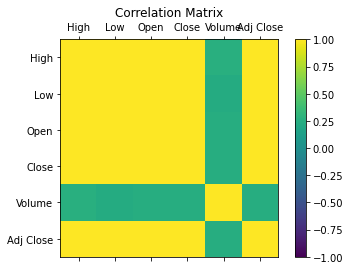

The average of the opening and closing prices for Microsoft
+-------------+------------------+------------------+
|week_strt_day|   weekly_avg_open|   weekly_avg_open|
+-------------+------------------+------------------+
|   2017-01-01|  62.4399995803833| 62.50500011444092|
|   2017-01-08| 62.75599975585938| 62.75199966430664|
|   2017-01-15|  62.5649995803833|62.517499923706055|
|   2017-01-22| 63.87200088500977| 64.04199905395508|
|   2017-01-29| 64.33200073242188| 64.04199981689453|
|   2017-02-05|63.716000366210935|63.693999481201175|
|   2017-02-12| 64.47200012207031| 64.59199981689453|
|   2017-02-19| 64.47249984741211| 64.52250099182129|
|   2017-02-26|  64.2860008239746| 64.28200149536133|
|   2017-03-05| 64.54400177001953| 64.66399993896485|
|   2017-03-12|  64.7500015258789|  64.6760009765625|
|   2017-03-19|  64.9040023803711| 64.80400085449219|
|   2017-03-26| 65.15599975585937| 65.48600006103516|
|   2017-04-02| 65.78999938964844|  65.6500015258789|
|   2017-04-09| 65.479

22/05/21 22:28:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|          delta_high|           delta_low|          delta_open|         delta_close|
+-------------------+--------------------+--------------------+--------------------+--------------------+
|2017-01-03 00:00:00|                null|                null|                null|                null|
|2017-01-04 00:00:00|-0.09000015258789062|-0.01000213623046875| -0.3100013732910156| -0.2800025939941406|
|2017-01-05 00:00:00|-0.09000015258789062|-0.09000015258789062|-0.29000091552734375|                 0.0|
|2017-01-06 00:00:00|  0.4900016784667969| 0.01000213623046875|  0.1100006103515625|  0.5400009155273438|
|2017-01-09 00:00:00|-0.06999969482421875|                 0.5| 0.45999908447265625|-0.20000076293945312|
|2017-01-10 00:00:00|-0.01000213623046875|-0.26000213623046875|  -0.029998779296875|-0.02000045776367...|
|2017-01-11 00:00:00| 0.15999984741210938| 0.1

22/05/21 22:28:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-----------------+------------------+-----------------+-----------------+
|               Date|       delta_high|         delta_low|       delta_open|      delta_close|
+-------------------+-----------------+------------------+-----------------+-----------------+
|2017-01-03 00:00:00|             null|              null|             null|             null|
|2017-01-04 00:00:00| 0.91998291015625|               6.5| 0.47003173828125|   3.510009765625|
|2017-01-05 00:00:00|22.72003173828125|  6.05999755859375| 3.15997314453125|   23.27001953125|
|2017-01-06 00:00:00|17.03997802734375|   18.219970703125|20.80999755859375|15.53997802734375|
|2017-01-09 00:00:00| 2.33001708984375|     13.2900390625| 15.6400146484375| 0.92999267578125|
|2017-01-10 00:00:00|   -3.77001953125| -2.23004150390625| -1.4000244140625|-1.01995849609375|
|2017-01-11 00:00:00|              1.5| -0.02996826171875|-2.94000244140625|  3.1199951171875|
|2017-01-12 00:00:00| 14.6300048828125|    9.98999

22/05/21 22:28:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-------------------+-------------------+-------------------+-------------------+
|               Date|         delta_high|          delta_low|         delta_open|        delta_close|
+-------------------+-------------------+-------------------+-------------------+-------------------+
|2019-04-18 00:00:00|               null|               null|               null|               null|
|2019-04-22 00:00:00| 2.9000015258789062|-0.3810005187988281|               -4.0| 3.6999969482421875|
|2019-04-23 00:00:00| 5.2689971923828125|  5.610004425048828|  5.870002746582031| 3.3000030517578125|
|2019-04-24 00:00:00|-2.6689987182617188| -2.390003204345703|  4.529998779296875| -5.799999237060547|
|2019-04-25 00:00:00| -4.650001525878906|-0.5600013732910156| -6.660003662109375| 1.7999992370605469|
|2019-04-26 00:00:00| 0.1399993896484375|                1.0|    1.3800048828125|  1.220001220703125|
|2019-04-29 00:00:00| 1.5100021362304688| 1.1500015258789062|0.40999603271484375| 

22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-------------------+-------------------+-------------------+--------------------+
|               Date|         delta_high|          delta_low|         delta_open|         delta_close|
+-------------------+-------------------+-------------------+-------------------+--------------------+
|2017-01-03 00:00:00|               null|               null|               null|                null|
|2017-01-04 00:00:00|   1.82000732421875|  1.779998779296875| 1.5200042724609375|  1.8300018310546875|
|2017-01-05 00:00:00| 1.2899932861328125|  1.029998779296875|   1.30999755859375|  1.9799957275390625|
|2017-01-06 00:00:00| 2.9300003051757812| 1.7099990844726562| 2.1200027465820312|  2.7400054931640625|
|2017-01-09 00:00:00| 1.5500030517578125| 3.0100021362304688| 2.5699996948242188|  1.4899978637695312|
|2017-01-10 00:00:00|0.06999969482421875| 1.2399978637695312| 1.2699966430664062| -0.5500030517578125|
|2017-01-11 00:00:00| 0.6200027465820312| -0.220001220703125| -0.47000122

22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|          delta_high|           delta_low|          delta_open|         delta_close|
+-------------------+--------------------+--------------------+--------------------+--------------------+
|2017-01-03 00:00:00|                null|                null|                null|                null|
|2017-01-04 00:00:00| 0.04500007629394531|  0.2474994659423828|0.012498855590820312|  -0.032501220703125|
|2017-01-05 00:00:00| 0.08749961853027344|  0.0149993896484375|0.017499923706054688| 0.14750099182128906|
|2017-01-06 00:00:00|  0.3250007629394531| 0.16500091552734375| 0.21500015258789062|  0.3250007629394531|
|2017-01-09 00:00:00| 0.31749916076660156| 0.36750030517578125|  0.2924995422363281| 0.26999855041503906|
|2017-01-10 00:00:00|-0.01250076293945...| 0.09000015258789062|  0.2049999237060547|0.030000686645507812|
|2017-01-11 00:00:00| 0.13750076293945312| 0.0

22/05/21 22:28:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------+-------------------+-----------------+
|company_name|               Date|      dailyReturn|
+------------+-------------------+-----------------+
|      GOOGLE|2017-01-03 00:00:00| 7.33001708984375|
|      GOOGLE|2017-01-04 00:00:00|    -1.4599609375|
|      GOOGLE|2017-01-05 00:00:00| 7.94000244140625|
|      GOOGLE|2017-01-06 00:00:00| 10.8900146484375|
|      GOOGLE|2017-01-09 00:00:00|             0.25|
|      GOOGLE|2017-01-10 00:00:00|-3.07000732421875|
|      GOOGLE|2017-01-11 00:00:00| 2.90997314453125|
|      GOOGLE|2017-01-12 00:00:00|  -0.780029296875|
|      GOOGLE|2017-01-13 00:00:00|  0.4000244140625|
|      GOOGLE|2017-01-17 00:00:00|-2.47003173828125|
|      GOOGLE|2017-01-18 00:00:00|   0.260009765625|
|      GOOGLE|2017-01-19 00:00:00|-2.94500732421875|
|      GOOGLE|2017-01-20 00:00:00|-1.88995361328125|
|      GOOGLE|2017-01-23 00:00:00|12.05999755859375|
|      GOOGLE|2017-01-24 00:00:00| 1.57000732421875|
|      GOOGLE|2017-01-25 00:00:00| 6.049987792

22/05/21 22:28:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|          delta_high|           delta_low|          delta_open|         delta_close|
+-------------------+--------------------+--------------------+--------------------+--------------------+
|2017-01-03 00:00:00|                null|                null|                null|                null|
|2017-01-04 00:00:00|    1.53399658203125|  0.6699981689453125|-0.02199935913085...|                 2.0|
|2017-01-05 00:00:00|-0.10400009155273438|  1.5279998779296875|  2.3339996337890625|-0.04800033569335...|
|2017-01-06 00:00:00|  0.5660018920898438|  0.7000007629394531| 0.10200119018554688|  0.4519996643066406|
|2017-01-09 00:00:00| 0.32199859619140625|  0.5099983215332031| 0.40799713134765625| 0.45400238037109375|
|2017-01-10 00:00:00|0.016002655029296875| -0.2220001220703125|  0.6060028076171875| -0.2820014953613281|
|2017-01-11 00:00:00| -0.4040031433105469|-0.0

22/05/21 22:28:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+------------------+------------------+
|               Date|              Open|    moving_average|
+-------------------+------------------+------------------+
|2017-01-03 00:00:00|62.790000915527344|62.790000915527344|
|2017-01-04 00:00:00| 62.47999954223633|62.635000228881836|
|2017-01-05 00:00:00|62.189998626708984| 62.48666636149088|
|2017-01-06 00:00:00| 62.29999923706055|  62.4399995803833|
|2017-01-09 00:00:00|  62.7599983215332| 62.50399932861328|
|2017-01-10 00:00:00| 62.72999954223633| 62.54166603088379|
|2017-01-11 00:00:00| 62.61000061035156| 62.51166598002116|
|2017-01-12 00:00:00|63.060001373291016| 62.60833295186361|
|2017-01-13 00:00:00|62.619998931884766|62.679999669392906|
|2017-01-17 00:00:00| 62.68000030517578|62.743333180745445|
|2017-01-18 00:00:00| 62.66999816894531|62.728333155314125|
|2017-01-19 00:00:00|  62.2400016784668|62.646666844685875|
|2017-01-20 00:00:00| 62.66999816894531| 62.65666643778483|
|2017-01-23 00:00:00| 62.70000076293945|

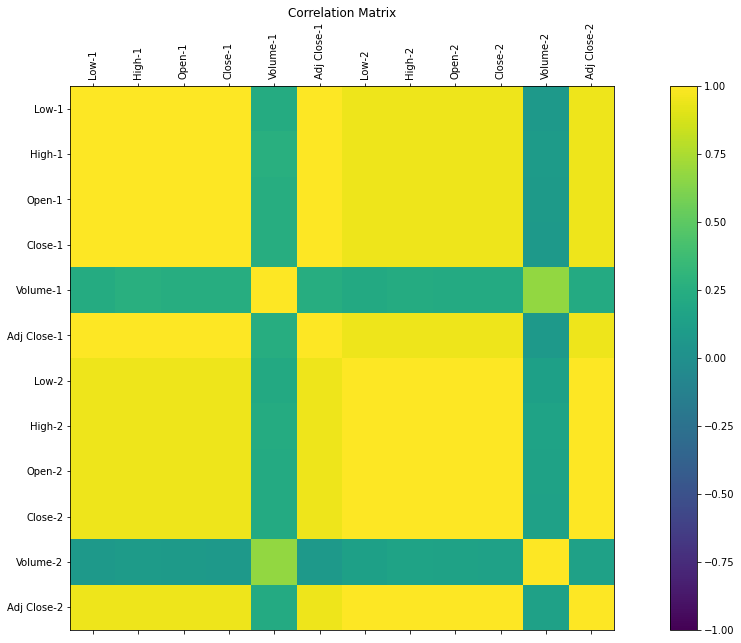

The return rate for Microsoft
Microsoft's weekly return rate  -0.09555880301982586
Microsoft's monthly return rate  0.7325992638405951
Microsoft's annualy return rate  37.06003552121619
Microsoft's best return rate on January 2017 is 4.618572198749188 at 2017-01-30 00:00:00
The following insights will be done on Microsoft stocks


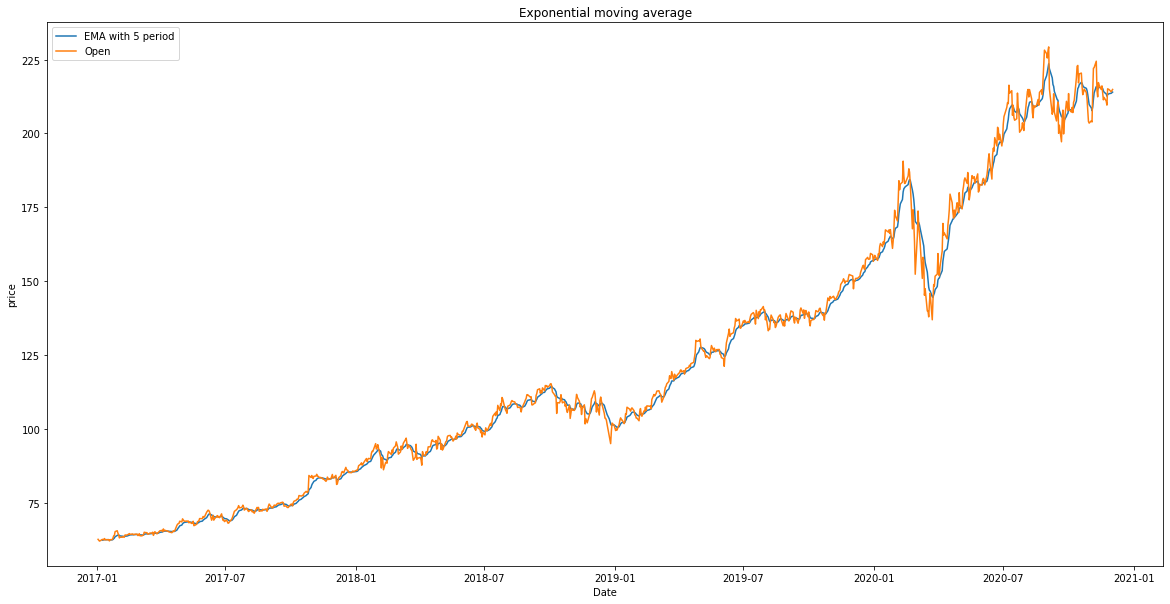

22/05/21 22:28:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/21 22:28:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


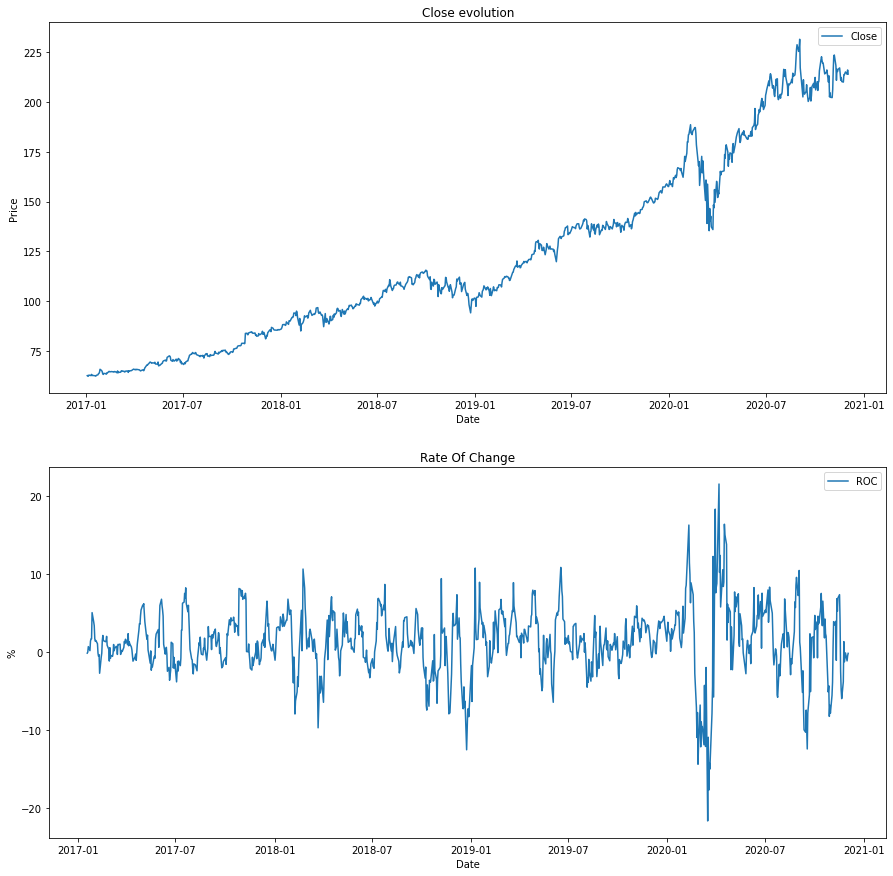

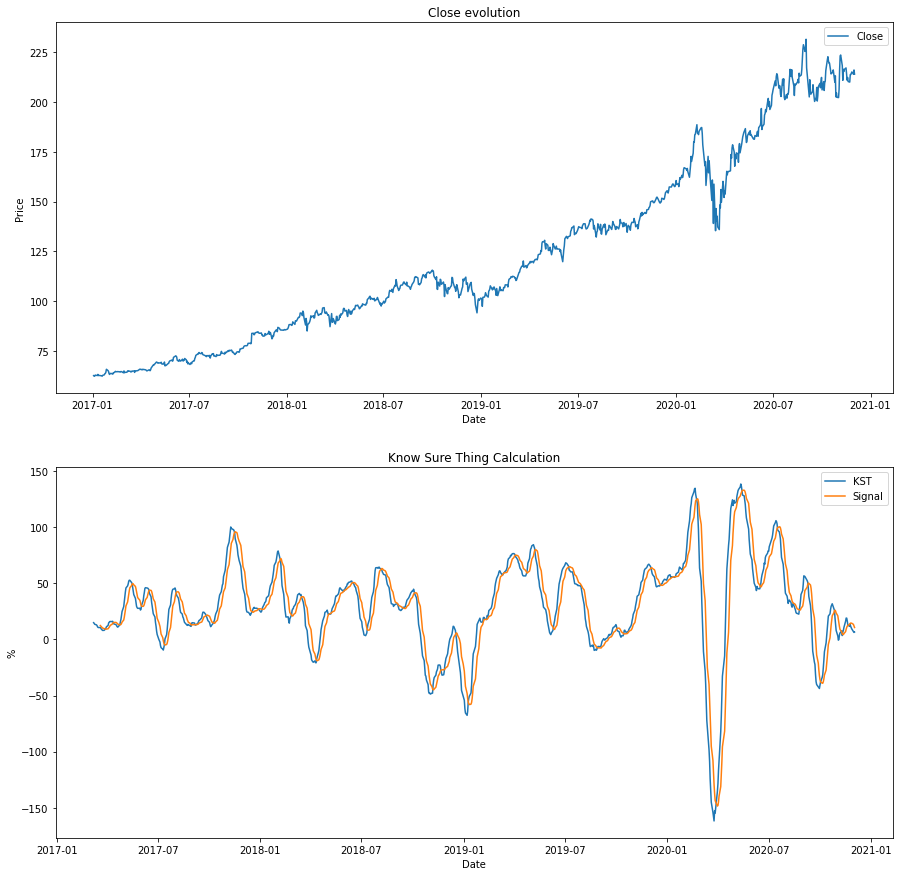

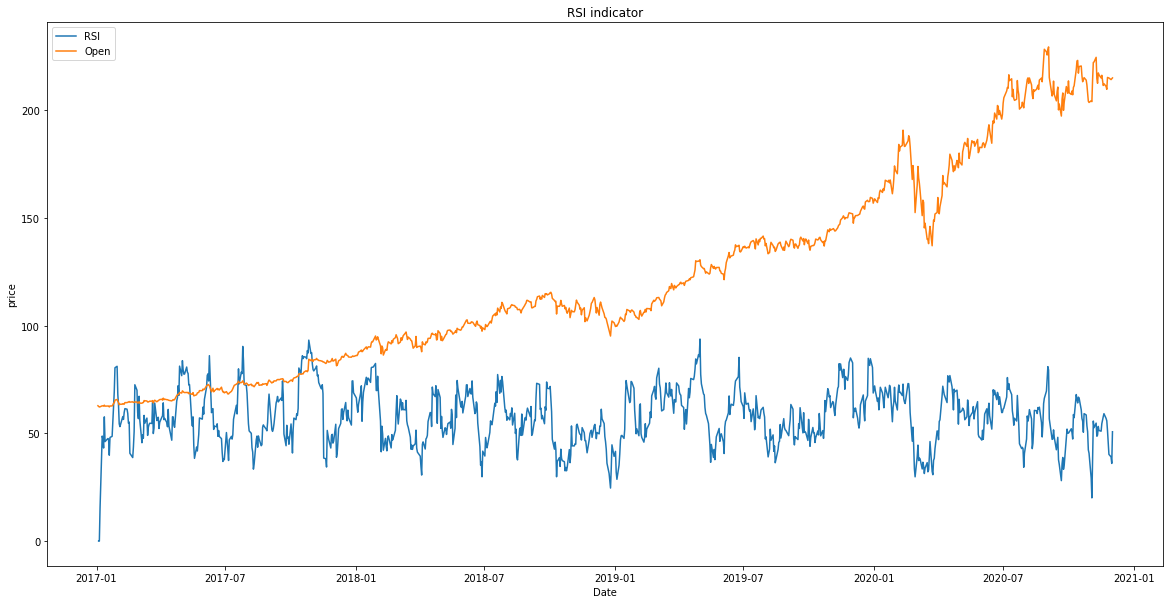

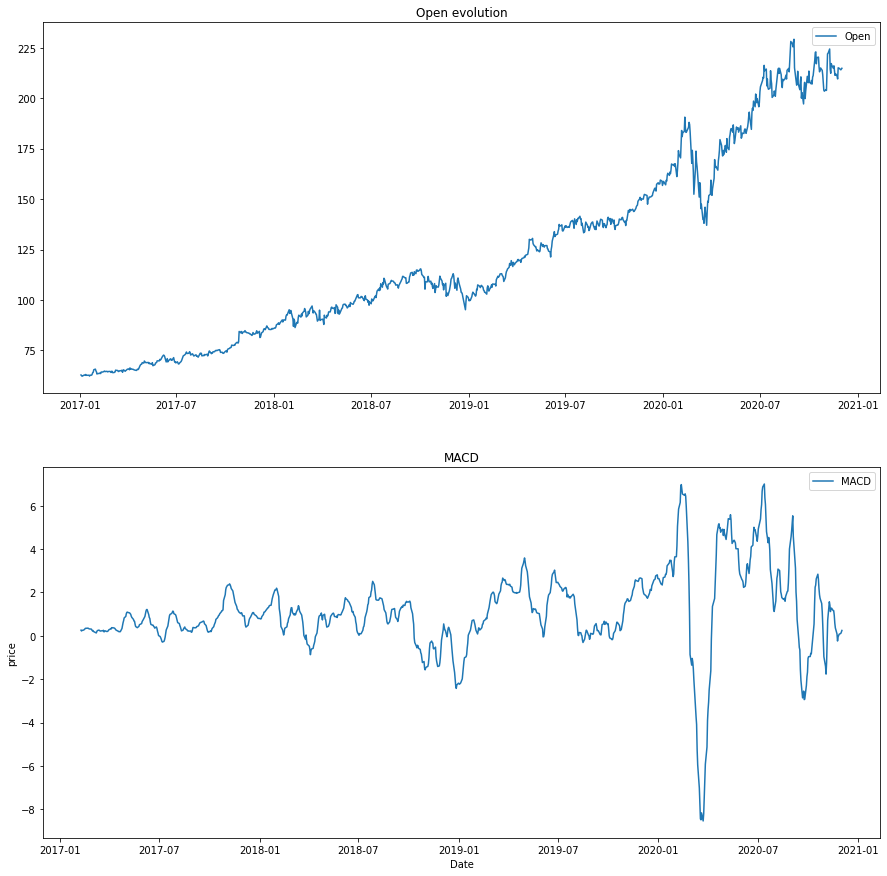

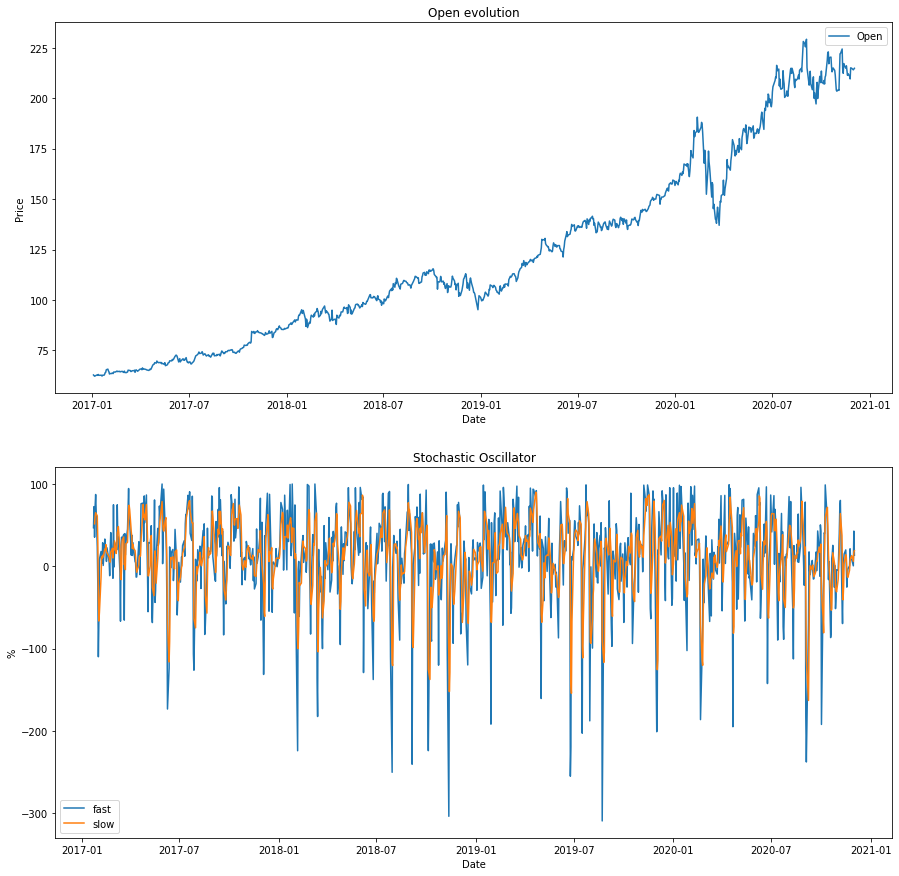

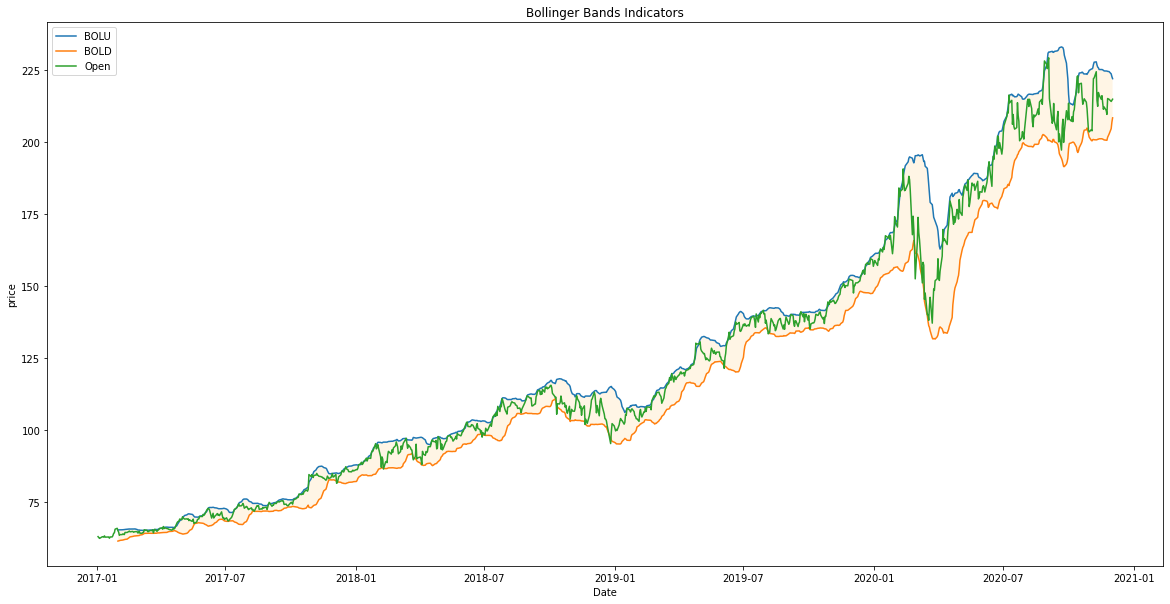

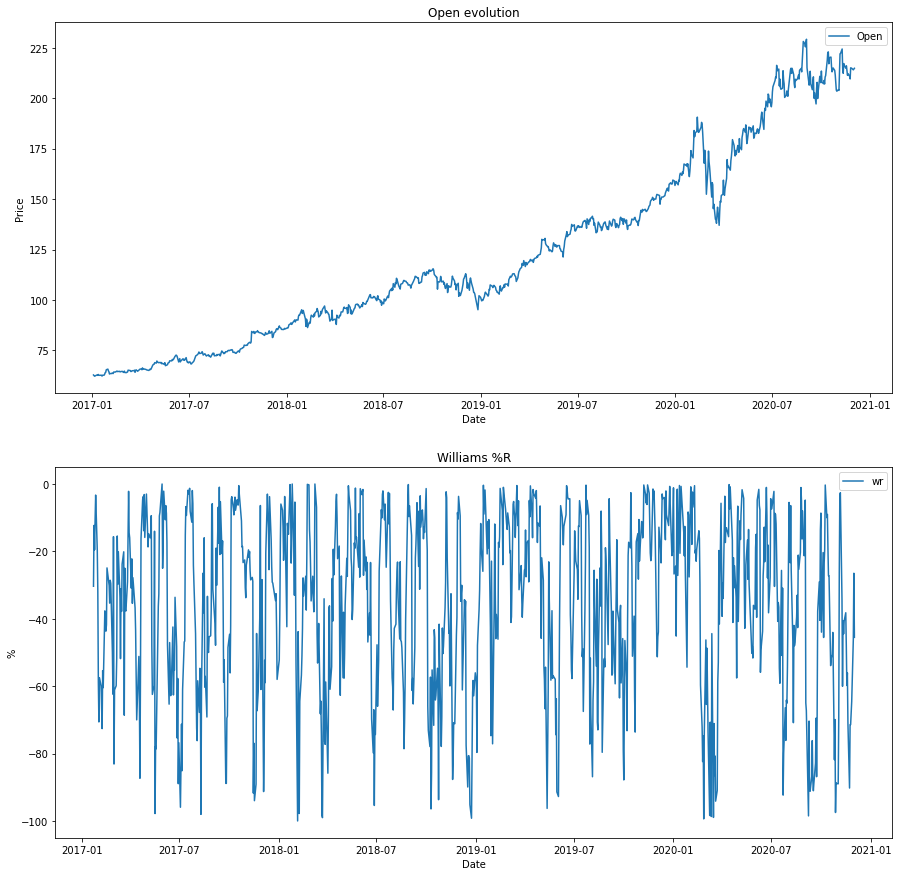

In [29]:
def main():
    microsoft_path = 'stocks_data/MICROSOFT.csv'
    amazon_path = 'stocks_data/AMAZON.csv'
    zoom_path = 'stocks_data/ZOOM.csv'
    facebook_path = 'stocks_data/FACEBOOK.csv'
    apple_path = 'stocks_data/APPLE.csv'
    google_path = 'stocks_data/GOOGLE.csv'
    tesla_path = 'stocks_data/TESLA.csv'
    
    
    # Define schema
    stocksColumns = [StructField("Date",TimestampType()), StructField("High",DoubleType()), 
              StructField("Low",DoubleType()), StructField("Open",DoubleType()),
              StructField("Close",DoubleType()), StructField("Volume", DoubleType()), 
              StructField("Adj Close",DoubleType()), StructField("company_name", StringType())]

    stocksSchema = StructType(stocksColumns)
    
    
    microsoft = get_data(microsoft_path, stocksSchema, delimiter=',')
    amazon = get_data(amazon_path, stocksSchema, delimiter=',')
    zoom = get_data(zoom_path, stocksSchema, delimiter=',')
    facebook = get_data(facebook_path, stocksSchema, delimiter=',')
    apple = get_data(apple_path, stocksSchema, delimiter=',')
    google = get_data(google_path, stocksSchema, delimiter=',')
    tesla = get_data(tesla_path, stocksSchema, delimiter=',')
    
    stocks = [(microsoft, 'Microsoft'), 
              (amazon, 'Amazon'), 
              (zoom, 'Zoom'), 
              (facebook, 'Facebook'), 
              (apple, 'Apple'),
              (google, 'Google'),
              (tesla, 'Testla')]
    
    print('First 40 rows of Microsoft')
    show_first_rows(microsoft)
    
    print('Last 40 rows of Microsoft')
    show_last_rows(microsoft)
    
    get_num_rows(microsoft)
    
    get_period(microsoft)
    
    
    for stock, name in stocks:
        print('The discribe statistics for ' + name)
        get_stats(stock)
    
    print('Na value of each columns for Microsoft')
    get_na(microsoft)
    
    print("Microsoft's correlation matrix")
    plot_corr(microsoft)
     
    
    for stock, name in stocks:
        print("The average of the opening and closing prices for " + name)
        get_period_avg(stock).show()
        get_period_avg(stock, 'month').show()
        get_period_avg(stock, 'year').show()
        
        print('The stocks evolution for ' + name)
        get_evolution(stock).show()
        
        print('The daily return for ' + name)
        dailyReturn(stock).show()
        print('The best daily return for ' + name)
        bestDailyReturn(stock).show()
        print('The average daily return for ' + name)
        averageDailyReturnByWeek(stock).show()
        averageDailyReturnByMonth(stock).show()
        averageDailyReturnByYear(stock).show()
        
        
    print('The following analysis will be done on Microsoft stocks')
    
    print('The moving average for Microsoft on openning and closing price')
    moving_averge(microsoft).show()
    
    print('The correlation matrix between Microsoft and Amazon')
    corr_with(microsoft, amazon)
    
    print('The return rate for Microsoft')
    print("Microsoft's weekly return rate " , RoR(microsoft, "2017-01-03", "week"))
    print("Microsoft's monthly return rate ", RoR(microsoft, "2017-01-03", "month"))
    print("Microsoft's annualy return rate ", RoR(microsoft, "2017-01-03", "year"))
    
    day, ror = bestRoR(microsoft, "2017-01-03", "month")
    print("Microsoft's best return rate on January 2017 is", ror, 'at', day)
    
    print('The following insights will be done on Microsoft stocks')

    get_EMA(microsoft)

    get_ROC(microsoft)

    get_KST(microsoft)

    get_RSI(microsoft)

    get_MACD(microsoft)

    get_StochasticOscillator(microsoft)

    get_BollingerBands(microsoft)

    get_Rwilliams(microsoft)
    
    
    

if __name__ == '__main__':
    main()